<a href="https://colab.research.google.com/github/Enrico-Call/RL-AKI/blob/main/3_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo" width=128px/>

# VUmc Research Project - Reinforcement Learning for Sepsis Prevention
# Data Preparation

AmsterdamUMCdb version 1.0.2 March 2020  
Copyright &copy; 2003-2022 Amsterdam UMC - Amsterdam Medical Data Science

### 1. Load Data and Set Up Environment

In [1]:
!pip install pyclust
!pip install treelib

import os
import math
import numbers
import sys
import sklearn
import itertools
import re
import dateutil
import random
import scipy
import pyclust
import copy

import pandas as pd
import matplotlib.colors as cl
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np

from google.colab import drive
from scipy.stats import norm
from scipy import stats
from sklearn.neighbors import DistanceMetric
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from nltk.cluster.kmeans import KMeansClusterer

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MLRFH')

aggregated = pd.read_csv('aggregated.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


## 2. Clustering

### 2.1. Define Helper Functions 

From Mark Hoogendoorn and Burkhardt Funk (2017), Machine Learning for the Quantified Self, Springer         

In [2]:
class VisualizeDataset:

    point_displays = ['+', 'x'] #'*', 'd', 'o', 's', '<', '>']
    line_displays = ['-'] #, '--', ':', '-.']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # Set some initial attributes to define and create a save location for the images.
    def __init__(self):
        pass

    # Plot the dataset, here columns can specify a specific attribute, but also a generic name that occurs
    # among multiple attributes (e.g. label which occurs as labelWalking, etc). In such a case they are plotted
    # in the same graph. The display should express whether points or a line should be plotted.
    # Match can be 'exact' or 'like'. Display can be 'points' or 'line'.
    def plot_dataset(self, data_table, columns, match='like', display='line'):
        names = list(data_table.columns)

        # Create subplots if more columns are specified.
        if len(columns) > 1:
            f, xar = plt.subplots(len(columns), sharex=True, sharey=False)
        else:
            f, xar = plt.subplots()
            xar = [xar]

        f.subplots_adjust(hspace=0.4)

        xfmt = md.DateFormatter('%H:%M')

        # Pass through the columns specified.
        for i in range(0, len(columns)):
            xar[i].xaxis.set_major_formatter(xfmt)
            xar[i].set_prop_cycle(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
            # if a column match is specified as 'exact', select the column name(s) with an exact match.
            # If it's specified as 'like', select columns containing the name.

            # We can match exact (i.e. a columns name is an exact name of a columns or 'like' for
            # which we need to find columns names in the dataset that contain the name.
            if match[i] == 'exact':
                relevant_cols = [columns[i]]
            elif match[i] == 'like':
                relevant_cols = [name for name in names if columns[i] == name[0:len(columns[i])]]
            else:
                raise ValueError("Match should be 'exact' or 'like' for " + str(i) + ".")

            max_values = []
            min_values = []



            # Pass through the relevant columns.
            for j in range(0, len(relevant_cols)):
                # Create a mask to ignore the NaN and Inf values when plotting:
                mask = data_table[relevant_cols[j]].replace([np.inf, -np.inf], np.nan).notnull()
                max_values.append(data_table[relevant_cols[j]][mask].max())
                min_values.append(data_table[relevant_cols[j]][mask].min())

                # Display point, or as a line
                if display[i] == 'points':
                    xar[i].plot(data_table.index[mask], data_table[relevant_cols[j]][mask],
                                self.point_displays[j%len(self.point_displays)])
                else:
                    xar[i].plot(data_table.index[mask], data_table[relevant_cols[j]][mask],
                                self.line_displays[j%len(self.line_displays)])

            xar[i].tick_params(axis='y', labelsize=10)
            xar[i].legend(relevant_cols, fontsize='xx-small', numpoints=1, loc='upper center',
                          bbox_to_anchor=(0.5, 1.3), ncol=len(relevant_cols), fancybox=True, shadow=True)

            xar[i].set_ylim([min(min_values) - 0.1*(max(max_values) - min(min_values)),
                             max(max_values) + 0.1*(max(max_values) - min(min_values))])

        # Make sure we get a nice figure with only a single x-axis and labels there.
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.xlabel('time')
        plt.show()

    def plot_xy(self, x, y, method='plot', xlabel=None, ylabel=None, xlim=None, ylim=None, names=None,
                line_styles=None, loc=None, title=None):
        for input in x, y:
            if not hasattr(input[0], '__iter__'):
                raise TypeError('x/y should be given as a list of lists of coordinates')

        plot_method = getattr(plt, method)
        for i, (x_line, y_line) in enumerate(zip(x, y)):

            plot_method(x_line, y_line, line_styles[i]) if line_styles is not None else plt.plot(x_line, y_line)

            if xlabel is not None: plt.xlabel(xlabel)
            if ylabel is not None: plt.ylabel(ylabel)
            if xlim is not None: plt.xlim(xlim)
            if ylim is not None: plt.ylim(ylim)
            if title is not None: plt.title(title)
            if names is not None: plt.legend(names)

        plt.show()

    def plot_dataset_boxplot(self, dataset, cols):
        plt.Figure(); dataset[cols].plot.box()
        plt.ylim([-30,30])
        plt.show()

    # This function plots the real and imaginary amplitudes of the frequencies found in the Fourier transformation.
    def plot_fourier_amplitudes(self, freq, ampl_real, ampl_imag):
        plt.xlabel('Freq(Hz)')
        plt.ylabel('amplitude')
        # Plot the real values as a '+' and imaginary in the same way (though with a different color).
        plt.plot(freq, ampl_real, '+', freq, ampl_imag,'+')
        plt.legend(['real', 'imaginary'], numpoints=1)
        self.save(plt)
        plt.show()

    # Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    # column and outlier_col the columns with a binary value (outlier or not)
    def plot_binary_outliers(self, data_table, col, outlier_col):
        data_table.loc[:,:] = data_table.dropna(axis=0, subset=[col, outlier_col])
        data_table.loc[:,outlier_col] = data_table[outlier_col].astype('bool')
        f, xar = plt.subplots()
        xfmt = md.DateFormatter('%H:%M')
        xar.xaxis.set_major_formatter(xfmt)
        plt.xlabel('time')
        plt.ylabel('value')
        # Plot data points that are outliers in red, and non outliers in blue.
        xar.plot(data_table.index[data_table[outlier_col]], data_table[col][data_table[outlier_col]], 'r+')
        xar.plot(data_table.index[~data_table[outlier_col]], data_table[col][~data_table[outlier_col]], 'b+')
        plt.legend(['outlier ' + col, 'no_outlier_' + col], numpoints=1, fontsize='xx-small', loc='upper center',  ncol=2, fancybox=True, shadow=True)
        plt.show()

    # Plot values that have been imputed using one of our imputation approaches. Here, values expresses the
    # 1 to n datasets that have resulted from value imputation.
    def plot_imputed_values(self, data_table, names, col, *values):

        xfmt = md.DateFormatter('%H:%M')

        # Create proper subplots.
        if len(values) > 0:
            f, xar = plt.subplots(len(values) + 1, sharex=True, sharey=False)
        else:
            f, xar = plt.subplots()
            xar = [xar]

        f.subplots_adjust(hspace=0.4)

        # plot the regular dataset.

        xar[0].xaxis.set_major_formatter(xfmt)
        xar[0].plot(data_table.index[data_table[col].notnull()], data_table[col][data_table[col].notnull()], 'b+', markersize='2')
        xar[0].legend([names[0]], fontsize='small', numpoints=1, loc='upper center',  bbox_to_anchor=(0.5, 1.3), ncol=1, fancybox=True, shadow=True)

        # and plot the others that have resulted from imputation.
        for i in range(1, len(values)+1):
            xar[i].xaxis.set_major_formatter(xfmt)
            xar[i].plot(data_table.index, values[i-1], 'b+', markersize='2')
            xar[i].legend([names[i]], fontsize='small', numpoints=1, loc='upper center',  bbox_to_anchor=(0.5, 1.3), ncol=1, fancybox=True, shadow=True)

        # Diplay is nicely in subplots.
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.xlabel('time')
        plt.show()

    # This function plots clusters that result from the application of a clustering algorithm
    # and also shows the class label of points. Clusters are displayed via colors, classes
    # by means of different types of points. We assume that three data columns are clustered
    # that do not include the label. We assume the labels to be represented by 1 or more binary
    # columns.
    def plot_clusters_3d(self, data_table, data_cols, cluster_col, label_cols):

        color_index = 0
        point_displays = ['+', 'x', '*', 'd', 'o', 's', '<', '>']

        # Determine the number of clusters:
        clusters = data_table[cluster_col].unique()
        labels = []

        # Get the possible labels, assuming 1 or more label columns with binary values.
        for i in range(0, len(label_cols)):
            labels.extend([name for name in list(data_table.columns) if label_cols[i] == name[0:len(label_cols[i])]])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        handles = []

        # Plot clusters individually with a certain color.
        for cluster in clusters:
            marker_index = 0
            # And make sure the points of a label receive the right marker type.
            for label in labels:
                rows = data_table.loc[(data_table[cluster_col] == cluster) & (data_table[label] > 0)]
                # Now we come to the assumption that there are three data_cols specified:
                if not len(data_cols) == 3:
                    return
                plot_color = self.colors[color_index%len(self.colors)]
                plot_marker = point_displays[marker_index%len(point_displays)]
                pt = ax.scatter(rows[data_cols[0]], rows[data_cols[1]], rows[data_cols[2]], c=plot_color, marker=plot_marker)
                if color_index == 0:
                    handles.append(pt)
                ax.set_xlabel(data_cols[0])
                ax.set_ylabel(data_cols[1])
                ax.set_zlabel(data_cols[2])
                marker_index += 1
            color_index += 1

        plt.legend(handles, labels, fontsize='xx-small', numpoints=1)
        plt.show()

    # This function plots the silhouettes of the different clusters that have been identified. It plots the
    # silhouette of the individual datapoints per cluster to allow studying the clusters internally as well.
    # For this, a column expressing the silhouette for each datapoint is assumed.
    def plot_silhouette(self, data_table, cluster_col, silhouette_col):
        # Taken from the examples of scikit learn
        #(http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

        clusters = data_table[cluster_col].unique()

        fig, ax1 = plt.subplots(1, 1)
        ax1.set_xlim([-0.1, 1])
        #ax1.set_ylim([0, len(data_table.index) + (len(clusters) + 1) * 10])
        y_lower = 10
        for i in range(0, len(clusters)):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            rows = data_table.mask(data_table[cluster_col] == clusters[i])
            ith_cluster_silhouette_values = np.array(rows[silhouette_col])
            ith_cluster_silhouette_values.sort()

            size_cluster_i = len(rows.index)
            y_upper = y_lower + size_cluster_i

            color = plt.get_cmap('Spectral')(float(i) / len(clusters))
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=data_table[silhouette_col].mean(), color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.show()

    # Plot a dendorgram for hierarchical clustering. It assumes that the linkage as
    # used in sk learn is passed as an argument as well.
    def plot_dendrogram(self, dataset, linkage):
        sys.setrecursionlimit(40000)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('time points')
        plt.ylabel('distance')
        times = dataset.index.strftime('%H:%M:%S')
        #dendrogram(linkage,truncate_mode='lastp',p=10, show_leaf_counts=True, leaf_rotation=90.,leaf_font_size=12.,show_contracted=True, labels=times)
        dendrogram(linkage,truncate_mode='lastp',p=16, show_leaf_counts=True, leaf_rotation=45.,leaf_font_size=8.,show_contracted=True, labels=times)
        plt.show()

    # Plot the confusion matrix that has been derived in the evaluation metrics. Classes expresses the labels
    # for the matrix. We can normalize or show the raw counts. Of course this applies to classification problems.
    def plot_confusion_matrix(self, cm, classes, normalize=False):
        # Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

        # Select the colormap.
        cmap=plt.cm.Blues
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title('confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    # This function plots the predictions or an algorithms (both for the training and test set) versus the real values for
    # a regression problem. It assumes only a single value to be predicted over a number of cases. The variables identified
    # with reg_ are the predictions.
    def plot_numerical_prediction_versus_real(self, train_time, train_y, regr_train_y, test_time, test_y, regr_test_y, label):
        self.legends = {}

        # Plot the values, training set cases in blue, test set in red.
        f, xar = plt.subplots(1, 1)

        xfmt = md.DateFormatter('%H:%M')
        xar.xaxis.set_major_formatter(xfmt)
        xar.set_prop_cycle(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
        plt.plot(train_time, train_y, '-', linewidth=0.5)
        plt.plot(train_time, regr_train_y, '--', linewidth=0.5)

        plt.plot(test_time, test_y, '-', linewidth=0.5)
        plt.plot(test_time, regr_test_y, '--', linewidth=0.5)

        plt.legend(['real values training', 'predicted values training', 'real values test', 'predicted values test'], loc=4)


        # And create some fancy stuff in the figure to label the training and test set a bit clearer.
        max_y_value = max(max(train_y.tolist()), max(regr_train_y.tolist()), max(test_y.tolist()), max(regr_test_y.tolist()))
        min_y_value = min(min(train_y.tolist()), min(regr_train_y.tolist()), min(test_y.tolist()), min(regr_test_y.tolist()))
        range = max_y_value - min_y_value
        y_coord_labels = max(max(train_y.tolist()), max(regr_train_y.tolist()), max(test_y.tolist()), max(regr_test_y.tolist()))+(0.01*range)


        plt.title('Performance of model for ' + str(label))
        plt.ylabel(label)
        plt.xlabel('time')
        plt.annotate('', xy=(train_time[0],y_coord_labels), xycoords='data', xytext=(train_time[-1], y_coord_labels), textcoords='data', arrowprops={'arrowstyle': '<->'})
        plt.annotate('training set', xy=(train_time[int(float(len(train_time))/2)], y_coord_labels*1.02), color='blue', xycoords='data', ha='center')
        plt.annotate('', xy=(test_time[0], y_coord_labels), xycoords='data', xytext=(test_time[-1], y_coord_labels), textcoords='data', arrowprops={'arrowstyle': '<->'})
        plt.annotate('test set', xy=(test_time[int(float(len(test_time))/2)], y_coord_labels*1.02), color='red', xycoords='data', ha='center')
        plt.show()

    # Plot the Pareto front for multi objective optimization problems (for the dynamical systems stuff). We consider the
    # raw output of the MO dynamical systems approach, which includes rows with the fitness and predictions for the training
    # and test set. We select the fitness and plot them in a graph. Note that the plot only considers the first two dimensions.
    def plot_pareto_front(self, dynsys_output):
        fit_1_train = []
        fit_2_train = []
        fit_1_test = []
        fit_2_test = []
        for row in dynsys_output:
            fit_1_train.append(row[1][0])
            fit_2_train.append(row[1][1])

        plt.scatter(fit_1_train, fit_2_train, color='r')
        plt.xlabel('mse on ' + str(dynsys_output[0][0].columns[0]))
        plt.ylabel('mse on ' + str(dynsys_output[0][0].columns[1]))
        #plt.savefig('{0} Example ({1}).pdf'.format(ea.__class__.__name__, problem.__class__.__name__), format='pdf')
        plt.show()

    # Plot a prediction for a regression model in case it concerns a multi-objective dynamical systems model. Here, we plot
    # the individual specified. Again, the complete output of the MO approach is used as argument.
    def plot_numerical_prediction_versus_real_dynsys_mo(self, train_time, train_y, test_time, test_y, dynsys_output, individual, label):
        regr_train_y = dynsys_output[individual][0][label]
        regr_test_y = dynsys_output[individual][2][label]
        train_y = train_y[label]
        test_y = test_y[label]
        self.plot_numerical_prediction_versus_real(train_time, train_y, regr_train_y, test_time, test_y, regr_test_y, label)

    # Visualizes the performance of different algorithms over different feature sets. Assumes the scores to contain
    # a score on the training set followed by an sd, and the same for the test set.
    def plot_performances(self, algs, feature_subset_names, scores_over_all_algs, ylim, std_mult, y_name):

        width = float(1)/(len(feature_subset_names)+1)
        ind = np.arange(len(algs))
        for i in range(0, len(feature_subset_names)):
            means = []
            std = []
            for j in range(0, len(algs)):
                means.append(scores_over_all_algs[i][j][2])
                std.append(std_mult * scores_over_all_algs[i][j][3])
            plt.errorbar(ind + i * width, means, yerr=std, fmt=self.colors[i%len(self.colors)] + 'o', markersize='3')
        plt.ylabel(y_name)
        plt.xticks(ind+(float(len(feature_subset_names))/2)*width, algs)
        plt.legend(feature_subset_names, loc=4, numpoints=1)
        if not ylim is None:
            plt.ylim(ylim)
        plt.show()

    def plot_performances_classification(self, algs, feature_subset_names, scores_over_all_algs):
        self.plot_performances(algs, feature_subset_names, scores_over_all_algs, [0.70, 1.0], 2, 'Accuracy')

    def plot_performances_regression(self, algs, feature_subset_names, scores_over_all_algs):
        self.plot_performances(algs, feature_subset_names, scores_over_all_algs, None, 1, 'Mean Squared Error')


# Class defining the distance metrics that are not available as standard ones....
class InstanceDistanceMetrics:

    # S for gowers distance
    def s(self, val1, val2, range):
        # If we compare numbers we look at the difference and normalize.
        if isinstance(val1, numbers.Number) and isinstance(val1, numbers.Number):
            return 1 - (float(abs(val1-val2))/range)
        # If we compare something else, we just look at whether they are equal.
        else:
            if val1 == val2:
                return 1
            else:
                return 0

    # Delta for gowers distance.
    def delta(self, val1, val2):
        # Check whether both values are known (i.e. nan), if so the delta is 1, 0 otherwise.
        if (not np.isnan(val1)) and (not np.isnan(val2)):
            return 1
        return 0

    # Define gowers distance between two rows, given the ranges of the variables
    # over the entire dataset (over all columns in row1 and row2)
    def gower_similarity(self, data_row1, data_row2, ranges):
        # We cannot computer if the lengths are not equal.
        if len(data_row1.columns) != len(data_row2.columns):
            return -1

        delta_total = 0
        s_total = 0

        # iterate over all columns.
        for i in range(0, len(data_row1.columns)):
            val1 = data_row1[data_row1.columns[i]].values[0]
            val2 = data_row2[data_row2.columns[i]].values[0]
            # compute the delta
            delta = self.delta(val1, val2)
            delta_total = delta_total + delta
            if delta > 0:
                # and compute the s if the delta is above 0.
                s_total = s_total + self.s(val1, val2, ranges[i])
        return float(s_total)/delta_total

# Class to flatten datasets or compute the statistical difference between cases.
class PersonDistanceMetricsNoOrdering:

    gower = 'gower'
    minkowski = 'minkowski'

    # This returns a dataset with aggregated data instances based on the mean values
    # in the rows.
    def create_instances_mean(self, datasets):
        index = range(0, len(datasets))
        cols = datasets[0].columns
        new_dataset = pd.DataFrame(index=index, columns=cols)

        for i in range(0, len(datasets)):
            for col in cols:
                # Compute the mean per column and assign that
                # value for the row representing the current
                # dataset.
                new_dataset.iloc[i, new_dataset.columns.get_loc(col)] = datasets[i][col].mean()

        return new_dataset

    # Fit datasets to normal distribution and use parameters as instances
    def create_instances_normal_distribution(self, datasets):
        index = range(0, len(datasets))
        cols = datasets[0].columns
        new_cols = []
        # Create new columns for the parameters of the distribution.
        for col in cols:
            new_cols.append(col + '_mu')
            new_cols.append(col + '_sigma')
        new_dataset = pd.DataFrame(index=index, columns=new_cols)

        for i in range(0, len(datasets)):
            for col in cols:
                # Fit the distribution and assign the values to the
                # row representing the dataset.
                mu, sigma = norm.fit(datasets[i][col])
                new_dataset.iloc[i, new_dataset.columns.get_loc(col + '_mu')] = mu
                new_dataset.iloc[i, new_dataset.columns.get_loc(col + '_sigma')] = sigma

        return new_dataset

    # This defines the distance between datasets based on the statistical
    # differences between the distribution we can only compute
    # distances pairwise.
    def p_distance(self, dataset1, dataset2):

        cols = dataset1.columns
        distance = 0
        for col in cols:
            D, p_value = stats.ks_2samp(dataset1[col], dataset2[col])
            distance= distance + (1-p_value)
        return distance

# Class to compare two time ordered datasets.
class PersonDistanceMetricsOrdering:

    extreme_value = sys.float_info.max
    tiny_value = 0.000001

    # Directly pair up the datasets and computer the euclidean
    # distances between the sequences of values.
    def euclidean_distance(self, dataset1, dataset2):
        dist = DistanceMetric.get_metric('euclidean')
        if not len(dataset1.index) == len(dataset2.index):
            return -1
        distance = 0

        for i in range(0, len(dataset1.index)):
            data_row1 = dataset1.iloc[:,i:i+1].transpose()
            data_row2 = dataset2.iloc[:,i:i+1].transpose()
            ecl_dist = dist.pairwise(data_row1, data_row2)
            distance = distance + ecl_dist

        return distance

    # Compute the distance between two datasets given a set lag.
    def lag_correlation_given_lag(self, dataset1, dataset2, lag):
        distance = 0
        for i in range(0, len(dataset1.columns)):
            # consider the lengths of the series, and compare the
            # number of points in the smallest series.
            length_ds1 = len(dataset1.index)
            length_ds2 = len(dataset2.index) - lag
            length_used = min(length_ds1, length_ds2)
            if length_used < 1:
                return self.extreme_value
            # We multiply the values as expressed in the book.
            ccc = np.multiply(dataset1.ix[0:length_used, i].values, dataset2.ix[lag:length_used+lag, i].values)
            # We add the sum of the mutliplications to the distance. Correct for the difference in length.
            distance = distance + (float(1)/(float(max(ccc.sum(), self.tiny_value))))/length_used
        return distance

    # Compute the lag correlation. For this we find the best lag.
    def lag_correlation(self, dataset1, dataset2, max_lag):
        best_dist = -1
        best_lag = 0
        for i in range(0, max_lag+1):
            # Compute the distance given a lag.
            current_dist = self.lag_correlation_given_lag(dataset1, dataset2, i)
            if current_dist < best_dist or best_dist == -1:
                best_dist = current_dist
                best_lag = i
        return best_dist

    # Simple implementation of the dtw. Note that we use the euclidean distance here..
    # The implementation follows the algorithm explained in the book very closely.
    def dynamic_time_warping(self, dataset1, dataset2):
        # Create a distance matrix between all time points.
        cheapest_path = np.full((len(dataset1.index), len(dataset2.index)), self.extreme_value)
        cheapest_path[0,0] = 0
        DM = InstanceDistanceMetrics()


        for i in range(1, len(dataset1.index)):
            for j in range(1, len(dataset2.index)):
                data_row1 = dataset1.iloc[i:i+1,:]
                data_row2 = dataset2.iloc[j:j+1,:]
                d = sklearn.metrics.pairwise.euclidean_distances(data_row1, data_row2)
                cheapest_path[i,j] = d + min(cheapest_path[i-1, j], cheapest_path[i, j-1], cheapest_path[i-1, j-1])
        return cheapest_path[len(dataset1.index)-1, len(dataset2.index)-1]

# Implementation of the non hierarchical clustering approaches.
class NonHierarchicalClustering:

    # Global parameters for distance functions
    p = 1
    max_lag = 1

    # Identifiers of the various distance and abstraction approaches.
    euclidean = 'euclidean'
    minkowski = 'minkowski'
    manhattan = 'manhattan'
    gower = 'gower'
    abstraction_mean = 'abstraction_mean'
    abstraction_normal = 'abstraction_normal'
    abstraction_p = 'abstraction_p'
    abstraction_euclidean = 'abstract_euclidean'
    abstraction_lag = 'abstract_lag'
    abstraction_dtw = 'abstract_dtw'

    # Define the gowers distance between arrays to be used in k-means and k-medoids.
    def gowers_similarity(self, X, Y=None, Y_norm_squared=None, squared=False):
        X = np.matrix(X)
        distances = np.zeros(shape=(X.shape[0], Y.shape[0]))
        DM = InstanceDistanceMetrics()
        # Pairs up the elements in the dataset
        for x_row in range(0, X.shape[0]):
            data_row1 = pd.DataFrame(X[x_row])
            for y_row in range(0, Y.shape[0]):
                data_row2 = pd.DataFrame(Y[y_row]).transpose()
                # And computer the distance as defined in our distance metrics class.
                distances[x_row, y_row] = DM.gowers_similarity(data_row1, data_row2, self.p)
        return np.array(distances)

    # Use a predefined distance function for the Minkowski distance
    def minkowski_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('minkowski', p=self.p)
        return dist.pairwise(X, Y)

    # Use a predefined distance function for the Manhattan distance
    def manhattan_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('manhattan')
        return dist.pairwise(X, Y)

    # Use a predefined distance function for the Euclidean distance
    def euclidean_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('euclidean')
        return dist.pairwise(X, Y)

    # If we want to compare dataset between persons one approach is to flatten
    # each dataset to a single record/instance. This is done based on the approaches
    # we have defined in the distance metrics file.
    def aggregate_datasets(self, datasets, cols, abstraction_method):
        temp_datasets = []
        DM = PersonDistanceMetricsNoOrdering()

        # Flatten all datasets and add them to the newly formed dataset.
        for i in range(0, len(datasets)):
            temp_dataset = datasets[i][cols]
            temp_datasets.append(temp_dataset)

        if abstraction_method == self.abstraction_normal:
            return DM.create_instances_normal_distribution(temp_datasets)
        else:
            return DM.create_instances_mean(temp_datasets)

    # Perform k-means over an individual dataset.
    def k_means_over_instances(self, dataset, cols, k, distance_metric, max_iters, n_inits, p=1):

        # Take the appropriate columns.
        temp_dataset = dataset[cols]
        # Override the standard distance functions. Store the original first
        # sklearn_euclidian_distances = sklearn.cluster.k_means_.euclidean_distances
        sklearn_euclidian_distances = sklearn.metrics.pairwise.euclidean_distances
        if distance_metric == self.euclidean:
            sklearn.metrics.pairwise.euclidean_distances = self.euclidean_distance
        elif distance_metric == self.minkowski:
            self.p = p
            sklearn.metrics.pairwise.euclidean_distances = self.minkowski_distance
        elif distance_metric == self.manhattan:
            sklearn.metrics.pairwise.euclidean_distances = self.manhattan_distance
        elif distance_metric == self.gower:
            self.ranges = []
            for col in temp_dataset.columns:
                self.ranges.append(temp_dataset[col].max() - temp_dataset[col].min())
            sklearn.metrics.pairwise.euclidean_distances = self.gower_similarity
        # If we do not recognize the option we use the default distance function, which is much
        # faster....
        # Now apply the k-means algorithm
        kmeans = KMeans(n_clusters=k, max_iter=max_iters, n_init=n_inits, random_state=0).fit(temp_dataset)
        # Add the labels to the dataset
        dataset['cluster'] = kmeans.labels_
        # Compute the solhouette and add it as well.
        silhouette_avg = silhouette_score(temp_dataset, kmeans.labels_)
        silhouette_per_inst = silhouette_samples(temp_dataset, kmeans.labels_)
        dataset['silhouette'] = silhouette_per_inst

        # Reset the module distance function for further usage
        sklearn_euclidian_distances = sklearn_euclidian_distances

        return dataset

    # We have datasets covering multiple persons. We abstract the datatasets using an approach and create
    # clusters of persons.
    def k_means_over_datasets(self, datasets, cols, k, abstraction_method, distance_metric, max_iters, n_inits, p=1):
        # Convert the datasets to instances
        temp_dataset = self.aggregate_datasets(datasets, cols, abstraction_method)

        # And simply apply the instance based algorithm.....
        return self.k_means_over_instances(temp_dataset, temp_dataset.columns, k, distance_metric, max_iters, n_inits, p)

    # For our own k-medoids algorithm we use our own implementation. For this we computer a complete distance matrix
    # between points.
    def compute_distance_matrix_instances(self, dataset, distance_metric):
        # If the distance function is not defined in our distance metrics, we use the standard euclidean distance.
        if not (distance_metric in [self.manhattan, self.minkowski, self.gower, self.euclidean]):
            distances = sklearn.metrics.pairwise.euclidean_distances(X=dataset, Y=dataset)
            return pd.DataFrame(distances, index=range(0, len(dataset.index)), columns=range(0, len(dataset.index)))
        # Create an empty pandas dataframe for our distance matrix
        distances = pd.DataFrame(index=range(0, len(dataset.index)), columns=range(0, len(dataset.index)))
        DM = InstanceDistanceMetrics()

        # Define the ranges of the columns if we use the gower distance.
        ranges = []
        if distance_metric == self.gower:
            for col in dataset.columns:
                self.ranges.append(dataset[col].max() - dataset[col].min())

        # And compute the distances for each pair. Note that we assume the distances to be symmetric.
        for i in range(0, len(dataset.index)):
            for j in range(i, len(dataset.index)):
                if distance_metric == self.manhattan:
                    distances.iloc[i,j] = self.manhattan_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                elif distance_metric == self.minkowski:
                    distances.iloc[i,j] = self.manhattan_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:], self.p)
                elif distance_metric == self.gower:
                    distances.iloc[i,j] = self.gowers_similarity(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                elif distance_metric == self.euclidean:
                    distances.iloc[i,j] = self.euclidean_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                distances.iloc[j,i] = distances.iloc[i,j]
        return distances

    # We need to implement k-medoids ourselves to accommodate all distance metrics
    def k_medoids_over_instances(self, dataset, cols, k, distance_metric, max_iters, n_inits=5, p=1):
        # If we set it to default we use the pyclust package...
        temp_dataset = dataset[cols]
        if distance_metric == 'default':
            km = pyclust.KMedoids(n_clusters=k, n_trials=n_inits)
            km.fit(temp_dataset.values)
            cluster_assignment = km.labels_

        else:
            print("It workds")
            self.p = p
            cluster_assignment = []
            best_silhouette = -1

            # Compute all distances
            D = self.compute_distance_matrix_instances(temp_dataset, distance_metric)

            for it in range(0, n_inits):
                # First select k random points as centers:
                centers = random.sample(range(0, len(dataset.index)), k)
                prev_centers = []
                points_to_cluster = []

                n_iter = 0
                while (n_iter < max_iters) and not (centers == prev_centers):
                    n_iter += 1
                    prev_centers = centers
                    # Assign points to clusters.
                    points_to_centroid = D[centers].idxmin(axis=1)

                    new_centers = []
                    for i in range(0, k):
                    # And find the new center that minimized the sum of the differences.
                      
                        best_center = D.loc[points_to_centroid == centers[i]].sum().idxmin(axis=1)
                        new_centers.append(best_center)
                    centers = new_centers

                # Convert centroids to cluster numbers:

                points_to_centroid = D[centers].idxmin(axis=1)
                current_cluster_assignment = []
                for i in range(0, len(dataset.index)):
                    current_cluster_assignment.append(centers.index(points_to_centroid.iloc[i]))

                silhouette_avg = silhouette_score(temp_dataset, np.array(current_cluster_assignment))
                if silhouette_avg > best_silhouette:
                    cluster_assignment = current_cluster_assignment
                    best_silhouette = silhouette_avg

        # And add the clusters and silhouette scores to the dataset.
        dataset['cluster'] = cluster_assignment
        silhouette_avg = silhouette_score(temp_dataset, np.array(cluster_assignment))
        silhouette_per_inst = silhouette_samples(temp_dataset, np.array(cluster_assignment))
        dataset['silhouette'] = silhouette_per_inst

        return dataset

    # For k-medoids we use all possible distance metrics between datasets as well. For this we
    # again need to define a distance matrix between the datasets.
    def compute_distance_matrix_datasets(self, datasets, distance_metric):
        distances = pd.DataFrame(index=range(0, len(datasets)), columns=range(0, len(datasets)))
        DMNoOrdering = PersonDistanceMetricsNoOrdering()
        DMOrdering = PersonDistanceMetricsOrdering()

        # And compute the distances for each pair. Note that we assume the distances to be symmetric.
        for i in range(0, len(datasets)):
            for j in range(i, len(datasets)):
                if distance_metric == self.abstraction_p:
                    distances.iloc[i,j] = DMNoOrdering.p_distance(datasets[i], datasets[j])
                elif distance_metric == self.abstraction_euclidean:
                    distances.iloc[i,j] = DMOrdering.euclidean_distance(datasets[i], datasets[j])
                elif distance_metric == self.abstraction_lag:
                    distances.iloc[i,j] = DMOrdering.lag_correlation(datasets[i], datasets[j], self.max_lag)
                elif distance_metric == self.abstraction_dtw:
                    distances.iloc[i,j] = DMOrdering.dynamic_time_warping(datasets[i], datasets[j])
                distances.iloc[j,i] = distances.iloc[i,j]
        return distances

    # Note: distance metric only important in combination with certain abstraction methods as we allow for more
    # in k-medoids.
    def k_medoids_over_datasets(self, datasets, cols, k, abstraction_method, distance_metric, max_iters, n_inits=5, p=1, max_lag=5):
        self.p = p
        self.max_lag = max_lag

        # If we compare datasets by flattening them, we can simply flatten the dataset and apply the instance based
        # variant.
        if abstraction_method in [self.abstraction_mean, self.abstraction_normal]:
            # Convert the datasets to instances
            temp_dataset = self.aggregate_datasets(datasets, cols, abstraction_method)

            # And simply apply the instance based algorithm in case of
            return self.k_medoids_over_instances(temp_dataset, temp_dataset.columns, k, distance_metric, max_iters, n_inits=n_inits, p=p)

        # For the case over datasets we do not have a quality metric, therefore we just look at a single initialization for now (!)

        # First select k random points as centers:
        centers = random.sample(range(0, len(datasets)), k)
        prev_centers = []
        points_to_cluster = []
        # Compute all distances
        D = self.compute_distance_matrix_datasets(datasets, abstraction_method)

        n_iter = 0
        while (n_iter < max_iters) and not (centers == prev_centers):
            n_iter += 1
            prev_centers = centers
            # Assign points to clusters.
            points_to_centroid = D[centers].idxmin(axis=1)

            new_centers = []
            for i in range(0, k):
                # And find the new center that minimized the sum of the differences.
                best_center = D.loc[points_to_centroid == centers[i], points_to_centroid == centers[i]].sum().idxmin(axis=1)
                new_centers.append(best_center)
            centers = new_centers

        # Convert centroids to cluster numbers:

        points_to_centroid = D[centers].idxmin(axis=1)
        cluster_assignment = []
        for i in range(0, len(datasets)):
            cluster_assignment.append(centers.index(points_to_centroid.iloc[i,:]))

        dataset = pd.DataFrame(index=range(0, len(datasets)))
        dataset['cluster'] = cluster_assignment

        # Silhouette cannot be used here as it used a distance between instances, not datasets.

        return dataset

# In this class, we do not implement the Gover distance between instance, all others are included.
# Furthermore, we only implement the agglomerative approach.
class HierarchicalClustering:

    link = None

    # Perform agglomerative clustering over a single dataset.
    def agglomerative_over_instances(self, dataset, cols, max_clusters, distance_metric, use_prev_linkage=False, link_function='single'):
        temp_dataset = dataset[cols]
        df = NonHierarchicalClustering()

        if (not use_prev_linkage) or (self.link is None):
            # Perform the clustering process according to the specified distance metric.
            if distance_metric == df.manhattan:
                self.link = linkage(temp_dataset.values, method=link_function, metric='cityblock')
            else:
                self.link = linkage(temp_dataset.values, method=link_function, metric='euclidean')

        # And assign the clusters given the set maximum. In addition, compute the
        cluster_assignment = fcluster(self.link, max_clusters, criterion='maxclust')
        dataset['cluster'] = cluster_assignment
        silhouette_avg = silhouette_score(temp_dataset, np.array(cluster_assignment))
        silhouette_per_inst = silhouette_samples(temp_dataset, np.array(cluster_assignment))
        dataset['silhouette'] = silhouette_per_inst

        return dataset, self.link

    # Perform agglomerative clustering over the datasets by flattening them into a single dataset.
    def agglomerative_over_datasets(self, datasets, cols, max_clusters, abstraction_method, distance_metric, use_prev_linkage=False, link_function='single'):
        # Convert the datasets to instances
        df = NonHierarchicalClustering()
        temp_dataset = df.aggregate_datasets(datasets, cols, abstraction_method)

        # And simply apply the instance based algorithm...
        return self.agglomerative_over_instances(temp_dataset, temp_dataset.columns, max_clusters, distance_metric, use_prev_linkage=use_prev_linkage, link_function=link_function)

def k_means_over_instances(dataset, cols, k, max_iters, n_inits):

        # Take the appropriate columns.
        temp_dataset = dataset[cols]
        # Now apply the k-means algorithm
        kmeans = KMeans(n_clusters=k, max_iter=max_iters, n_init=n_inits, random_state=0).fit(temp_dataset)
        # Add the labels to the dataset
        dataset['cluster'] = kmeans.labels_
        # Compute the silhouette and add it as well.
        silhouette_avg = silhouette_score(temp_dataset, kmeans.labels_)
        silhouette_per_inst = silhouette_samples(temp_dataset, kmeans.labels_)
        dataset['silhouette'] = silhouette_per_inst

        return dataset, silhouette_avg

### 2.2. Perform Clustering Using K-Means

#### 2.2.1 First Check Best K Value (\#clusters) based on Silhouette Scores

===== kmeans clustering =====
k = 5
k = 10
k = 15
k = 20
k = 25
k = 30
k = 35
k = 40
k = 45
k = 50
k = 55
k = 60
k = 65
k = 70
k = 75
k = 80
k = 85
k = 90
k = 95
k = 100
k = 105
k = 110
k = 115
k = 120
k = 125
k = 130
k = 135
k = 140
k = 145
k = 150
k = 155
k = 160
k = 165
k = 170
k = 175
k = 180
k = 185
k = 190
k = 195
k = 200
k = 205
k = 210
k = 215
k = 220
k = 225
k = 230
k = 235
k = 240
k = 245
k = 250
k = 255
k = 260
k = 265
k = 270
k = 275
k = 280
k = 285
k = 290
k = 295
k = 300
k = 305
k = 310
k = 315
k = 320
k = 325
k = 330
k = 335
k = 340
k = 345
k = 350
k = 355
k = 360
k = 365
k = 370
k = 375
k = 380
k = 385
k = 390
k = 395
k = 400
k = 405
k = 410
k = 415
k = 420
k = 425
k = 430
k = 435
k = 440
k = 445
k = 450
k = 455
k = 460
k = 465
k = 470
k = 475
k = 480
k = 485
k = 490
k = 495


AttributeError: ignored

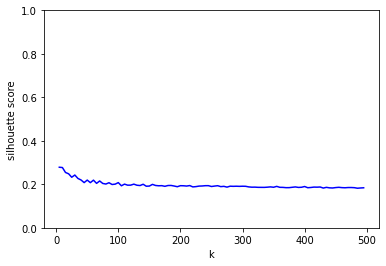

In [3]:
DataViz = VisualizeDataset()

clusteringNH = NonHierarchicalClustering()
clusteringH = HierarchicalClustering()

# Let us look at k-means first.
k_values = range(5, 500, 5)
silhouette_values = []

# Do some initial runs to determine the right number for k

print('===== kmeans clustering =====')
for k in k_values:
    # print(f'k = {k}')
    dataset_cluster = clusteringNH.k_means_over_instances(copy.deepcopy(
        aggregated), ['Kreatinine', 'Kreatinine (bloed)', 'KREAT enzym. (bloed)',
       'Urine', 'Chloor (bloed)', 'Natrium (bloed)',
       'Kalium (bloed)', 'HCO3', 'Natrium', 'Natrium Astrup',
       'Kalium Astrup', 'Chloor Astrup', 'Chloor', 'Kalium',
       'Act.HCO3 (bloed)', 'Na (onv.ISE) (bloed)', 'K (onv.ISE) (bloed)',
       'Cl (onv.ISE) (bloed)', 'Niet invasieve bloeddruk gemiddeld',
       'ABP gemiddeld II', 'ABP gemiddeld', 'agegroup', 'gender',
       'weightgroup', 'heightgroup'], k, 'default', 20, 10)
    silhouette_score_n = dataset_cluster['silhouette'].mean()
    # print(f'silhouette = {silhouette_score_n}')
    silhouette_values.append(silhouette_score_n)

DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0, 1], line_styles=['b-'])

# And run the knn with the highest silhouette score

k = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Means silhouette score: k = {k}')
print('Use this value of k to run the --mode=final --k=?')

#### 2.2.2. Then Check Elbow Plot (Sum of Squared Distances)

In [ ]:
Sum_of_squared_distances = []
K = range(2,500, 5)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(aggregated[['Kreatinine', 'Kreatinine (bloed)', 'KREAT enzym. (bloed)',
       'Urine', 'Chloor (bloed)', 'Natrium (bloed)',
       'Kalium (bloed)', 'HCO3', 'Natrium', 'Natrium Astrup',
       'Kalium Astrup', 'Chloor Astrup', 'Chloor', 'Kalium',
       'Act.HCO3 (bloed)', 'Na (onv.ISE) (bloed)', 'K (onv.ISE) (bloed)',
       'Cl (onv.ISE) (bloed)', 'Niet invasieve bloeddruk gemiddeld',
       'ABP gemiddeld II', 'ABP gemiddeld', 'agegroup', 'gender',
       'weightgroup', 'heightgroup']])
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'b-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### 2.2.3. Finally, perform K-Means Clustering using Best K Value

In [ ]:
# Use k=50 based on previous runs

new_d, sil = k_means_over_instances(aggregated, ['Kreatinine', 'Kreatinine (bloed)', 'KREAT enzym. (bloed)',
       'Urine', 'Chloor (bloed)', 'Natrium (bloed)',
       'Kalium (bloed)', 'HCO3', 'Natrium', 'Natrium Astrup',
       'Kalium Astrup', 'Chloor Astrup', 'Chloor', 'Kalium',
       'Act.HCO3 (bloed)', 'Na (onv.ISE) (bloed)', 'K (onv.ISE) (bloed)',
       'Cl (onv.ISE) (bloed)', 'Niet invasieve bloeddruk gemiddeld',
       'ABP gemiddeld II', 'ABP gemiddeld', 'agegroup', 'gender',
       'weightgroup', 'heightgroup'], 50, 20, 10)

## 3. Bin Values

### 3.1. Bin Action Space Values in 3 categories (0, Low, High)

In [ ]:
# Binning Values

binsv = [-np.inf, 0, 40, np.inf]
binsf = [-np.inf, 0.5, 1, np.inf]
labels = [0, 1, 2]
aggregated['vasop'] = pd.cut(aggregated['vasops_sum'], bins=binsv, labels=labels)
aggregated['fluid'] = pd.cut(aggregated['fluid_sum'], bins=binsf, labels=labels)

### 3.2. Create Actions based on combination of categoried (\#actions = n<sup>2</sup> categories)

In [ ]:
# 0 = no vasop, no fluid
# 1 = no vasop, low fluid
# 2 = no vasop, high fluid
# 3 = low vasop, no fluid
# 4 = low vasop, low fluid
# 5 = low vasop, high fluid
# 6 = high vasop, no fluid
# 7 = high vasop, low fluid
# 8 = high vasop, high fluid

act = []

for v, f in zip(aggregated['vasop'], aggregated['fluid']): 
  if v == 0 and f == 0: act.append('0')
  elif v == 0 and f == 1: act.append('1')
  elif v == 0 and f == 2: act.append('2')
  elif v == 1 and f == 0: act.append('3')
  elif v == 1 and f == 1: act.append('4')
  elif v == 1 and f == 2: act.append('5')
  elif v == 2 and f == 0: act.append('6')
  elif v == 2 and f == 1: act.append('7')
  elif v == 2 and f == 2: act.append('8')

aggregated['action'] = act

aggregated['reward'] = -aggregated['aki_stage']

aggregated['next'] = aggregated['cluster'].shift(-1)

final_space = aggregated.dropna()


## 4. Save DataFrame

In [ ]:
final_space.to_csv('final_space.csv')

## 5. Check DataFrame Statistics